*** 
**Author:** Danilo Cardoso
*** 
<center><img src="https://cdn-icons-png.flaticon.com/256/3526/3526120.png" width=80 height=80 /></center>
<h1><center>Exploring Mental Health Data</center></h1>


***
**About the Dataset:**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the **Depression Survey/Dataset** for Analysis dataset. Feature distributions are close to, but not exactly the same, as the original.


**Goal:**

Use data from a mental health survey to explore factors that may cause individuals to experience depression.

***

### <center> Dataset</center>


Variable  |Description |
-----|-----|
id|Unique identifier for each survey participant
Name|Name of the participant|
Gender|Gender of the participant|
Age|Age of the participant|
City|City of the participant
Working Professional or Student|whether the participant is a working professional or a student
Profession|Participant's profession (if employed)
Degree|Educational degree or qualification of the participant
Academic & Work Pressure| range [0&ndash;5]
CGPA|Cumulative Grade Point Average of the participant (if a student) range [0&ndash;10]
Study Satisfaction|range [0&ndash;5]
Job Satisfaction|range [0&ndash;5]
Sleep Duration| 'More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours', 'Other'
Dietary Habits| 'Healthy', 'Unhealthy', 'Moderate', 'Other'
Work/Study Hours|range [0&ndash;12]
Have you ever had suicidal thoughts?|Yes, No
Financial Stress|range [1&ndash;5]
Family History of Mental Illness| Yes, No
Depression| Risk of depression Yes, No



***
# Import Packages
***


In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib import cm 

from scipy.stats import chi2_contingency, stats
import researchpy as rp
from itertools import combinations

from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score,\
 precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


warnings.filterwarnings('ignore')

C:\Users\dcs13\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dcs13\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


***
# Import Data
***

In [3]:
train = pd.read_csv('datasets/train.csv').drop(columns='id')
test = pd.read_csv('datasets/test.csv').drop(columns='id')

original = pd.read_csv('datasets/final_depression_dataset_1.csv')

pd.set_option('display.max_columns', None)

***
# Gather Basic Information
***

### Train

In [4]:
print(f'Number of rows: {train.shape[0]} \nNumber of cols: {train.shape[1]}')

print('\n')

negative = train['Depression'][train['Depression'] == 0].count()
positive = train['Depression'][train['Depression'] == 1].count()

print(f'Negative: {negative}\nPositve: {positive} \n%Positive: {positive/(positive+negative):.2f}')

Number of rows: 140700 
Number of cols: 19


Negative: 115133
Positve: 25567 
%Positive: 0.18


***
Class slightly unbalanced
***

In [5]:
train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  

In [7]:
train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Age,140700.0,40.39,12.38,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.14,1.38,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,3.00,1.41,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.66,1.46,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.94,1.36,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.97,1.42,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.25,3.85,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.99,1.41,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.18,0.39,0.00,0.00,0.00,0.00,1.0


***

<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>


**Age:** Range 18 to 60

**Academic Pressure:** 1 to 5 - It contains NA's

**CGPA:** Range 5 to 10, Avg 7.66 (Indian's are smart). Lot's of NA's, considering that CGPA are just for students

**Study Satisfaction:** Range 1 to 5, Avg 2.94 (Not that bad)

**Job Satisfaction:** Range 1 to 5, Avg 2.97 (Also not that bad) half of it are below 3

**Work/Study Hours:** 0 to 12 Avg 6.25 - it contains students and professionals hours.

**Financial Stress:** Range 1 to 5 Avg 3 most people suffer from financial stress

**Depression:** 18% of the people are depressed
***

In [8]:
train.isna().sum()

Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [9]:
train[train.duplicated()]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression


### Test

In [10]:
print(f'Number of rows: {test.shape[0]} \nNumber of cols: {test.shape[1]}')

Number of rows: 93800 
Number of cols: 18


In [11]:
test.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [12]:
test.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Age,93800.0,40.32,12.39,18.00,29.00,42.0,51.00,60.0
Academic Pressure,18767.0,3.16,1.39,1.00,2.00,3.0,4.00,5.0
Work Pressure,75022.0,3.01,1.40,1.00,2.00,3.0,4.00,5.0
CGPA,18766.0,7.67,1.47,5.03,6.33,7.8,8.94,10.0
Study Satisfaction,18767.0,2.94,1.37,1.00,2.00,3.0,4.00,5.0
Job Satisfaction,75026.0,2.96,1.41,1.00,2.00,3.0,4.00,5.0
Work/Study Hours,93800.0,6.25,3.86,0.00,3.00,6.0,10.00,12.0
Financial Stress,93800.0,2.98,1.41,1.00,2.00,3.0,4.00,5.0


***

<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>

Features distribution from the testing set are close to the training set
***

### Original Survey Data

In [13]:
print(f'Number of rows: {original.shape[0]} \nNumber of cols: {original.shape[1]}')

print('\n')

negative = original['Depression'][original['Depression'] == 'No'].count()
positive = original['Depression'][original['Depression'] == 'Yes'].count()

print(f'Negative: {negative}\nPositve: {positive} \n%Positive: {positive/(positive+negative):.2f}')

Number of rows: 2556 
Number of cols: 19


Negative: 2101
Positve: 455 
%Positive: 0.18


In [14]:
original.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


In [15]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   2556 non-null   object 
 1   Gender                                 2556 non-null   object 
 2   Age                                    2556 non-null   int64  
 3   City                                   2556 non-null   object 
 4   Working Professional or Student        2556 non-null   object 
 5   Profession                             1883 non-null   object 
 6   Academic Pressure                      502 non-null    float64
 7   Work Pressure                          2054 non-null   float64
 8   CGPA                                   502 non-null    float64
 9   Study Satisfaction                     502 non-null    float64
 10  Job Satisfaction                       2054 non-null   float64
 11  Slee

In [16]:
original.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Age,2556.0,39.04,12.26,18.00,28.00,39.0,50.00,60.0
Academic Pressure,502.0,3.00,1.39,1.00,2.00,3.0,4.00,5.0
Work Pressure,2054.0,3.02,1.42,1.00,2.00,3.0,4.00,5.0
CGPA,502.0,7.57,1.47,5.03,6.21,7.6,8.82,10.0
Study Satisfaction,502.0,3.08,1.37,1.00,2.00,3.0,4.00,5.0
Job Satisfaction,2054.0,3.02,1.42,1.00,2.00,3.0,4.00,5.0
Work/Study Hours,2556.0,6.02,3.77,0.00,3.00,6.0,9.00,12.0
Financial Stress,2556.0,2.97,1.42,1.00,2.00,3.0,4.00,5.0


***

<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>

Features distribution from the original set are close to the training set
***

In [17]:
original.isna().sum()

Name                                        0
Gender                                      0
Age                                         0
City                                        0
Working Professional or Student             0
Profession                                673
Academic Pressure                        2054
Work Pressure                             502
CGPA                                     2054
Study Satisfaction                       2054
Job Satisfaction                          502
Sleep Duration                              0
Dietary Habits                              0
Degree                                      0
Have you ever had suicidal thoughts ?       0
Work/Study Hours                            0
Financial Stress                            0
Family History of Mental Illness            0
Depression                                  0
dtype: int64

In [18]:
original[original.duplicated()]

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression


In [19]:
# check for duplicates between dep_dataset and train dataset
(original[pd.concat([original[['Name', 'Gender', 'Age', 'City']], train[['Name', 'Gender', 'Age', 'City']]])
             .reset_index()
             .duplicated()]
)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression


In [20]:
pd.set_option('display.max_rows', 10)

***
# Exploratory Data Analysis
***

In [21]:
new_cols = (train.columns.str.lower()
              .str.replace(' ', '_')
              .str.replace('/', '_')
              .str.replace('have_you_ever_had_suicidal_thoughts_?', 'suicidal_thoughts')
        )

In [22]:
train.columns = new_cols
original.columns = new_cols
test.columns = new_cols[0:18]

***
Ajust the colum names
***

In [23]:
# Check the list of values for each column in the synthetic data
pd.set_option('display.max_rows', None)
for col in train.columns:
    if col != 'name':
        print(train[col].value_counts())

gender
Male      77464
Female    63236
Name: count, dtype: int64
age
56.0    5246
49.0    5099
38.0    4564
53.0    4526
57.0    4395
47.0    4199
46.0    4080
54.0    3928
51.0    3927
18.0    3921
43.0    3856
59.0    3781
48.0    3695
45.0    3535
20.0    3515
50.0    3439
42.0    3393
24.0    3355
28.0    3338
39.0    3262
44.0    3217
41.0    3140
33.0    3140
29.0    3097
40.0    3094
58.0    2932
25.0    2931
23.0    2900
55.0    2846
35.0    2834
21.0    2742
37.0    2724
36.0    2703
19.0    2634
27.0    2613
52.0    2589
34.0    2578
31.0    2560
60.0    2501
26.0    2108
22.0    2066
30.0    1912
32.0    1785
Name: count, dtype: int64
city
Kalyan                6591
Patna                 5924
Vasai-Virar           5765
Kolkata               5689
Ahmedabad             5613
Meerut                5528
Ludhiana              5226
Pune                  5210
Rajkot                5207
Visakhapatnam         5176
Srinagar              5074
Mumbai                4966
Indore           

dietary_habits
Moderate             49705
Unhealthy            46227
Healthy              44741
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64
degree
Class 12                14729
B.Ed                    11691
B.Arch                   8742
B.Com                    8113
B.Pharm                  5856
BCA                      5739
M.Ed                     5668
MCA                      5234
BBA                      5030
BSc                      5027
MSc                      4879
L

In [24]:
# Check the list of values for each column in the original data
pd.set_option('display.max_rows', None)
for col in original.columns:
    if col != 'name':
        print(original[col].value_counts())

gender
Male      1333
Female    1223
Name: count, dtype: int64
age
28    73
56    73
49    72
33    72
29    71
38    71
24    69
47    66
20    65
46    64
34    64
50    63
51    63
42    63
53    63
57    62
31    62
35    61
59    61
25    61
40    61
18    60
54    59
48    59
43    59
39    59
27    57
41    57
45    57
36    56
30    55
23    53
21    53
26    52
22    51
55    51
44    51
37    51
60    50
58    49
19    47
52    46
32    44
Name: count, dtype: int64
city
Srinagar         102
Meerut           101
Mumbai            99
Pune              98
Rajkot            96
Vasai-Virar       95
Kalyan            92
Ahmedabad         92
Patna             89
Chennai           88
Ludhiana          88
Vadodara          88
Kolkata           87
Hyderabad         85
Agra              85
Kanpur            84
Visakhapatnam     84
Varanasi          83
Indore            82
Bhopal            81
Surat             80
Jaipur            80
Thane             80
Nagpur            78
Bangalore  

***
<center><img src="https://i.ibb.co/MB4VJzZ/bulb.png" width=100 height=100/></center>


There some categorical values that are placed in the wrong column in the training set. 

 Ex: Some names and education are in the city column 
 ***

In [25]:
# Remove the wrong values
train_subset = train[train['city'].isin(original['city'])]

train_subset = train_subset[train_subset['profession'].isin(original['profession'])]

train_subset = train_subset[train_subset['sleep_duration'].isin(original['sleep_duration'])]

train_subset = train_subset[train_subset['dietary_habits'].isin(original['dietary_habits'])]

train_subset = train_subset[train_subset['degree'].isin(original['degree'])]

In [26]:
# % data removed
1-(len(train_subset)/len(train))

0.0026154939587775816

In [27]:
cols_corrected = ['city','profession','sleep_duration', 'dietary_habits', 'degree']

# Double check the summary
pd.set_option('display.max_rows', None)

for col in cols_corrected:
     print(train_subset[col].value_counts())

city
Kalyan           6583
Patna            5914
Vasai-Virar      5753
Kolkata          5676
Ahmedabad        5601
Meerut           5519
Ludhiana         5218
Pune             5203
Rajkot           5199
Visakhapatnam    5170
Srinagar         5052
Mumbai           4956
Indore           4863
Agra             4675
Surat            4631
Varanasi         4593
Vadodara         4557
Hyderabad        4487
Kanpur           4390
Jaipur           4320
Thane            4278
Lucknow          4273
Nagpur           4196
Bangalore        4117
Chennai          4039
Ghaziabad        3615
Delhi            3586
Bhopal           3466
Faridabad        3260
Nashik           3142
Name: count, dtype: int64
profession
Teacher                   24869
Content Writer             7804
Architect                  4359
Consultant                 4217
HR Manager                 4010
Pharmacist                 3882
Doctor                     3249
Business Analyst           3151
Entrepreneur               2960
Chemist   

### Good to go!

***
# Feature Engineering
***

In [28]:
# split the data into Synthetic and Original Survey Data to check data similarities
train_subset['Source'] = 'Synthetic'
original['Source'] = 'Original'

In [29]:
# label depression var
depression_map = {'No':0, 'Yes':1}

original['depression'] = original['depression'].map(depression_map)

In [30]:
# Union both datasets
mental_health = pd.concat([train_subset, original], axis=0).reset_index(drop=True)

In [31]:
# create an age group
mental_health['age_group'] = ['<=30' if val <= 30 else '31 - 40'
                          if val <= 40 else '41 - 50'
                          if val <= 50 else '51 - 60'
                          if val <=60 else '> 60'
                          for val in mental_health['age']]

In [32]:
# Combine Working Professional and Student vars
def set_student(df):
    df['working_professional_or_student'] = df['working_professional_or_student'].map({'Working Professional':'No', 'Student':'Yes'})
    df.rename(columns={'working_professional_or_student':'student'}, inplace=True)

In [33]:
set_student(mental_health)

In [34]:
# Combine Profession and student vars
def set_profession(df):
    df['profession'].loc[(df['student'] == 'Yes') & (df['profession'].isna())] = 'Student'
    df['profession'].loc[(df['student'] == 'No') & (df['profession'].isna())] = 'Unknown'

In [35]:
set_profession(mental_health)

In [36]:
# Combine academic pressure and work pressure vars
def set_work_academic_pressure(df):
    df['academic_pressure'].loc[(df['student'] == 'No') & (df['academic_pressure'].isna())] = mental_health['work_pressure']
   # df['Academic Pressure'].loc[df['Academic Pressure'].isna()] = mental_health['Academic Pressure'].mode()
    df.drop(columns='work_pressure', inplace=True)
    df.rename(columns={'academic_pressure':'academic_work_pressure'}, inplace=True)    

In [37]:
set_work_academic_pressure(mental_health)

In [38]:
# Replace students withtout cgpa with the average of cgpa
def set_cgpa(df):
    df['cgpa'].loc[(df['student'] == 'Yes') & (df['cgpa'].isna())] = df['cgpa'].mean()
    #df['CGPA'].loc[df['Student'] == 'No'] = df['CGPA'].mean() 

In [39]:
set_cgpa(mental_health)

In [40]:
# Combine study and job satisfaction vars
def set_study_job_satisfaction(df):
    df['study_satisfaction'].loc[(df['student'] == 'No') & (df['study_satisfaction'].isna())] = mental_health['job_satisfaction']
    df['study_satisfaction'].loc[df['study_satisfaction'].isna()] = mental_health['study_satisfaction'].mode()[0]
    df.drop(columns='job_satisfaction', inplace=True)
    df.rename(columns={'study_satisfaction':'study_job_satisfaction'}, inplace=True)
    

In [41]:
set_study_job_satisfaction(mental_health)

In [42]:
# Replace NA's in financial stress with the mode
def set_financial_stress(df):
    df['financial_stress'].fillna(df['financial_stress'].mode()[0], inplace=True)


In [43]:
set_financial_stress(mental_health)

In [44]:
# Binning work/study hours
def group_study_hrs(df):
    df['study_hours_groupped'] = ['< 5' if st < 5 else '5-8' if st <8 else '>8' for st in df['work_study_hours']] 

In [45]:
group_study_hrs(mental_health)

In [46]:
# Binning cgpa 
def group_cgpa(df):
    df['cgpa_groupped'] = ['Low' if st < 6 else 'Medium' if st <8 else 'High' for st in df['cgpa']] 

In [47]:
group_cgpa(mental_health)

In [48]:
#mental_health['overall_pressure_satisfaction_ratio'] = mental_health['Academic Work Pressure']/ (1-(mental_health['Study Job Satisfaction']))

In [49]:
categorical_var = ['gender', 'city', 'student', 'profession', 'sleep_duration', 'dietary_habits', 'degree', 'suicidal_thoughts',\
                   'family_history_of_mental_illness', 'age_group', 'degree_category', 'cgpa_groupped', 'study_hours_groupped']

discrete_var = ['academic_work_pressure', 'study_job_satisfaction', 'work_study_hours','financial_stress', 'age']

continous_var = ['cgpa']

In [50]:
# Binning Degree
degree = {
          'Undergraduate': ['B.Com', 'BE', 'BA', 'BCA', 'B.Ed', 'LLB', 'B.Arch', 'BBA', 'BHM', 'B.Tech', 'B.Pharm', 'BSc'],
          'High School': ['Class 12'],
          'Postgraduate' :['MA', 'M.Com', 'MCA', 'M.Tech', 'ME', 'MBA', 'M.Pharm', 'MSc', 'MHM', 'M.Ed', 'LLM'],
          'Professional/Doctorate' :['MBBS', 'MD', 'PhD']
         }

degree_cat = []
for d in mental_health['degree']:
    for k, v in degree.items():
        if d in v:
            degree_cat.append(k)
            
mental_health['degree_category'] = degree_cat

***
## Check data similarity
***


In [51]:
pd.set_option('display.max_rows', 10)

In [52]:
# Split he data into Original and Synthetic
mental_health_original = mental_health[mental_health['Source'] == 'Original']
mental_health_synthetic = mental_health[mental_health['Source'] == 'Synthetic']

In [53]:
pd.set_option('display.max_rows', 5)

In [54]:
col_palette = ['Yellow', 'Red']

In [55]:
# function to plot a pie chart 
def pie_chart(col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))   

    ax1.pie(mental_health_synthetic[col].value_counts(),
                   colors=col_palette,
                   autopct='%.1f%%')
    plt.legend(mental_health[col].unique())
    ax1.set_title(f'% {col} Synthetic Data')


    ax2.pie(mental_health_original[col].value_counts(),
                   colors=col_palette,
                   autopct='%.1f%%')
    plt.legend(mental_health['depression'].unique())
    ax2.set_title(f'% {col} Original Data');

In [56]:
# function to plot a stacked bar chart %
def stacked_chart(col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 

    df_grouped = mental_health_original.groupby(col)['depression'].value_counts(normalize=True).unstack('depression').sort_values(col, ascending=False)
    df_grouped.plot.bar(stacked=True, cmap=cm.get_cmap('viridis'), width=0.75 ,color=col_palette,ax=ax1)
    ax1.set_title(f'% {col} Original Data')
    ax1.set_ylabel('')

    df_grouped = mental_health_synthetic.groupby(col)['depression'].value_counts(normalize=True).unstack('depression').sort_values(col, ascending=False)
    df_grouped.plot.bar(stacked=True, cmap=cm.get_cmap('viridis'), width=0.75, color=col_palette, ax=ax2)
    ax2.set_title(f'% {col} Synthetic Data')
    ax2.set_ylabel('');

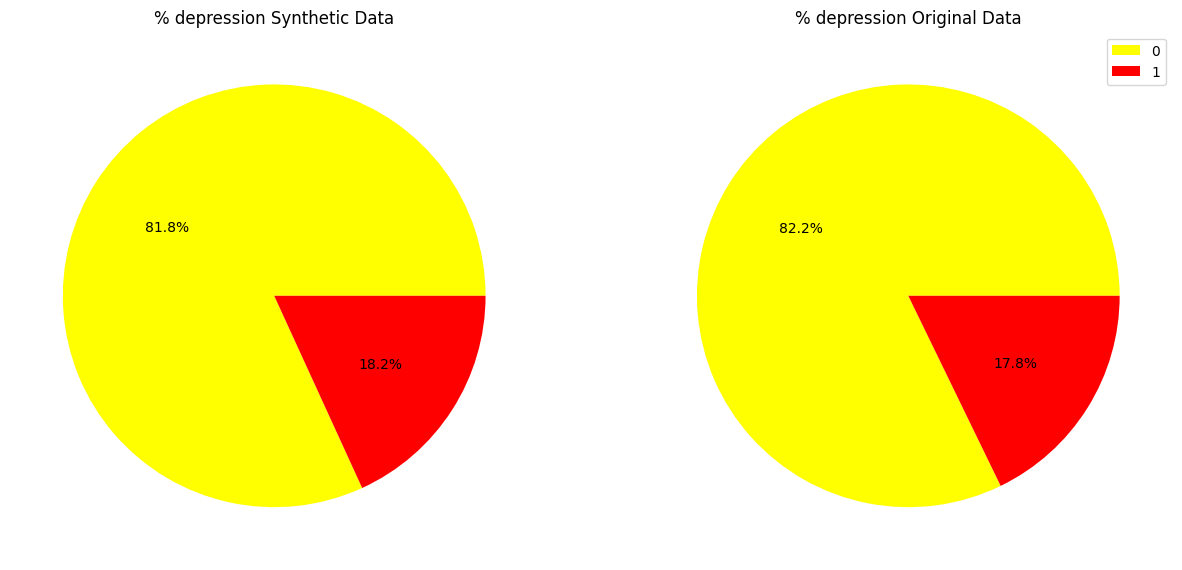

In [57]:
pie_chart('depression')

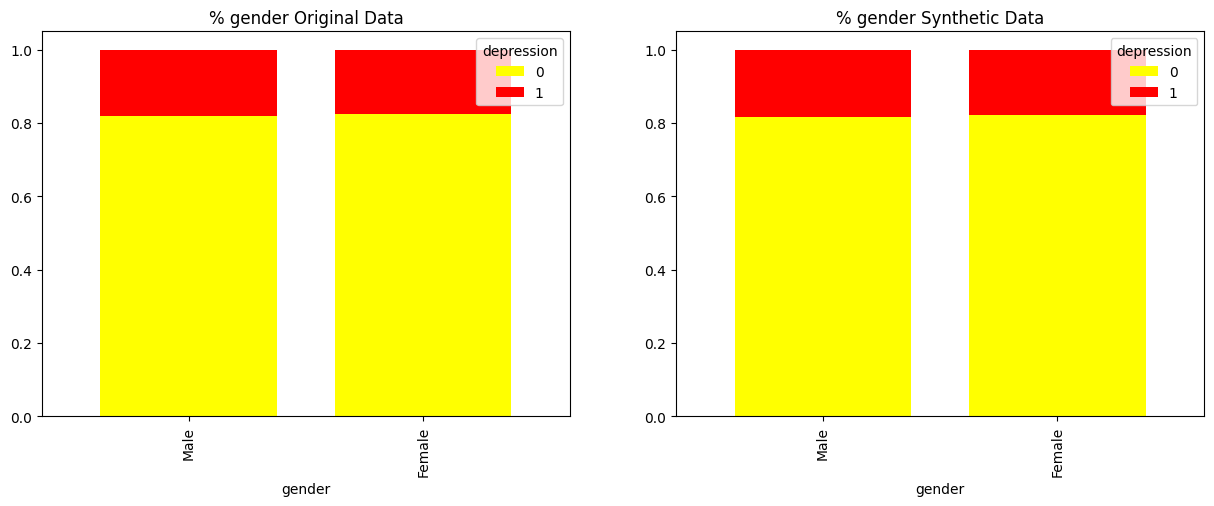

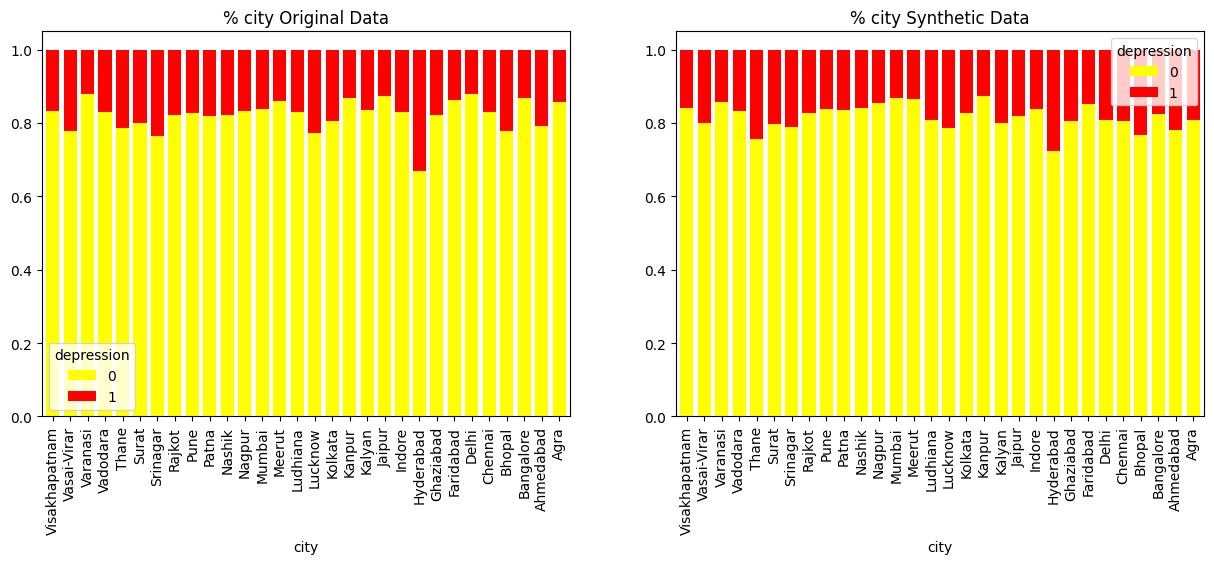

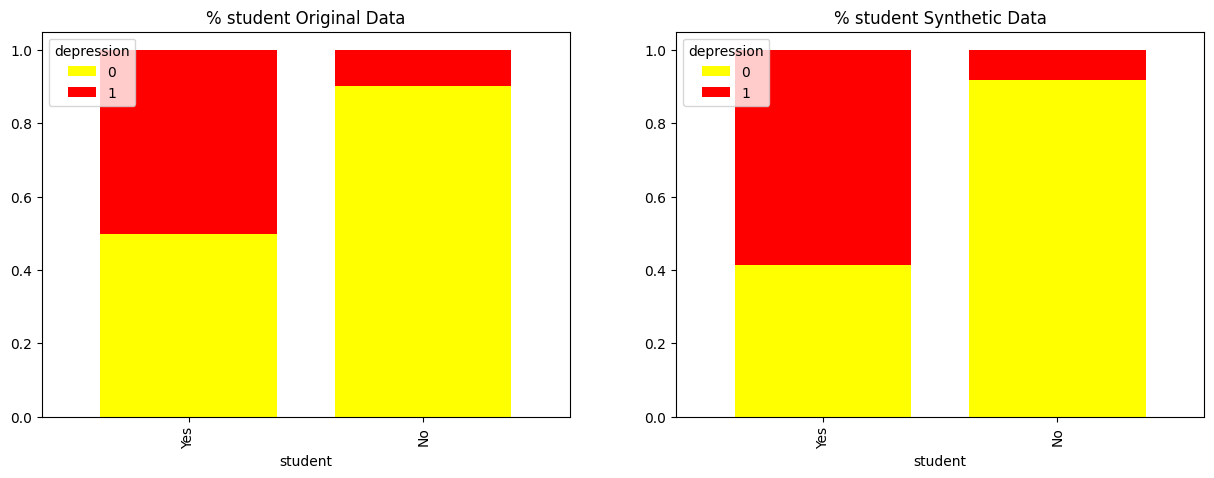

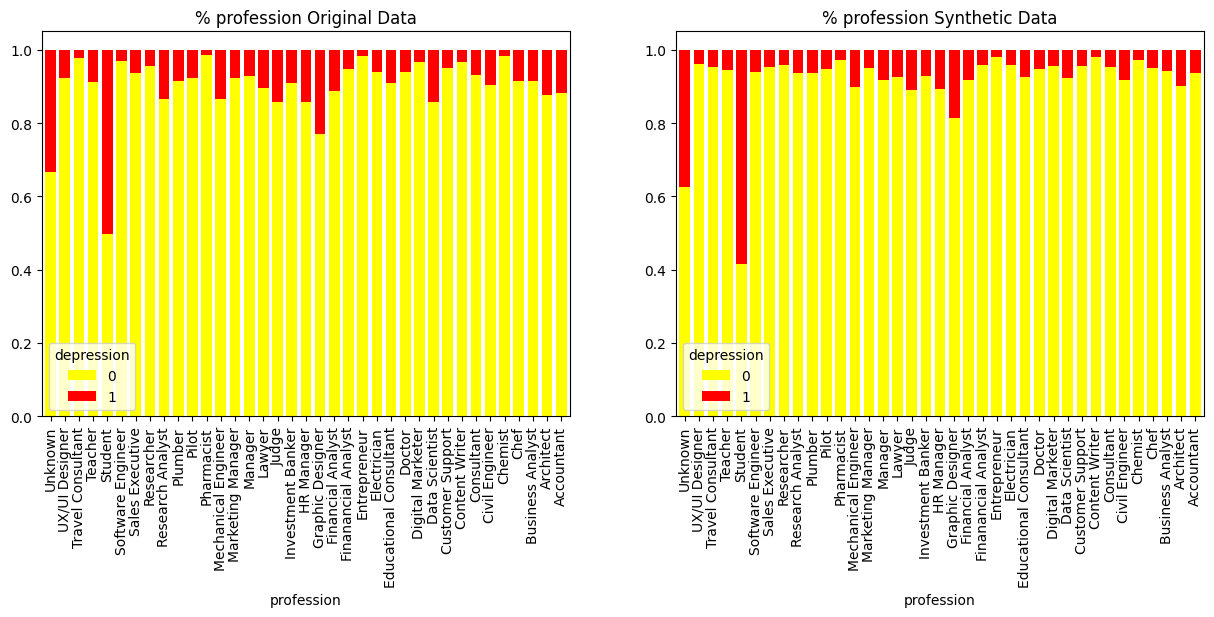

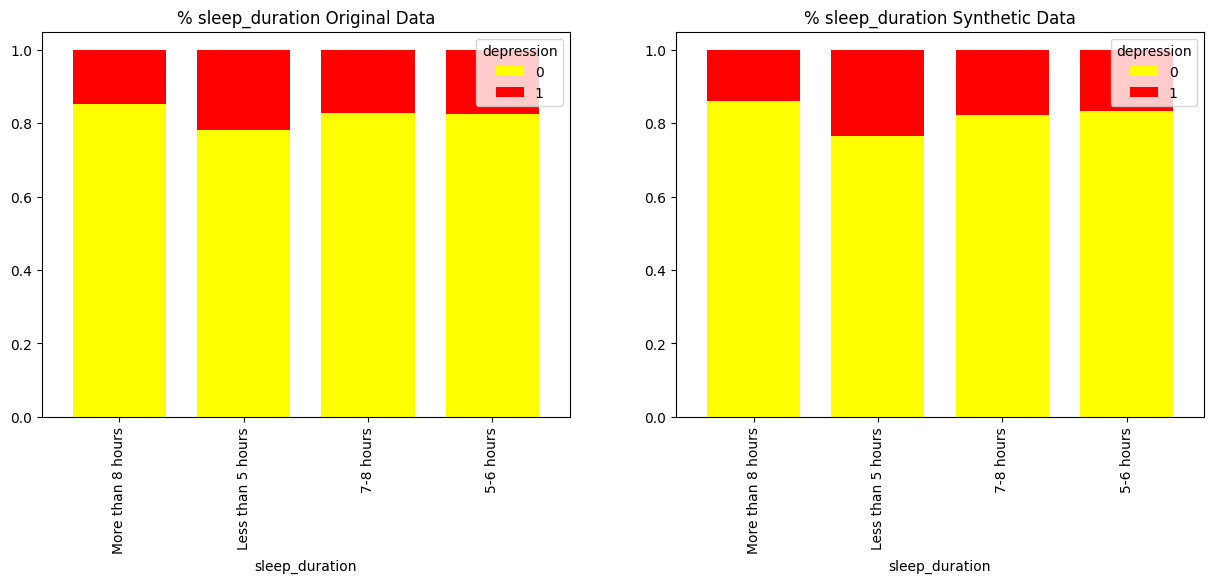

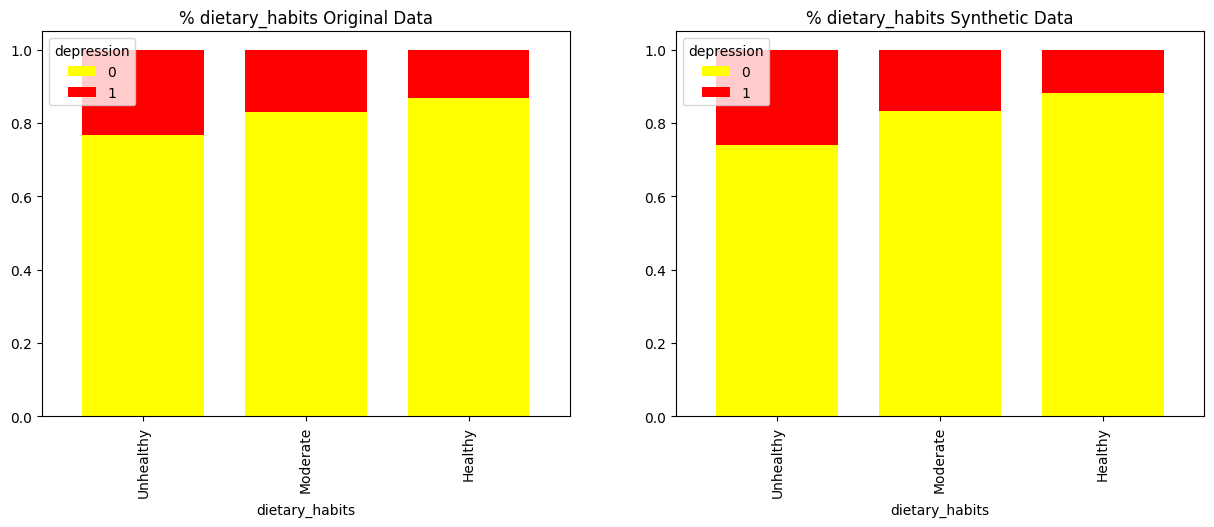

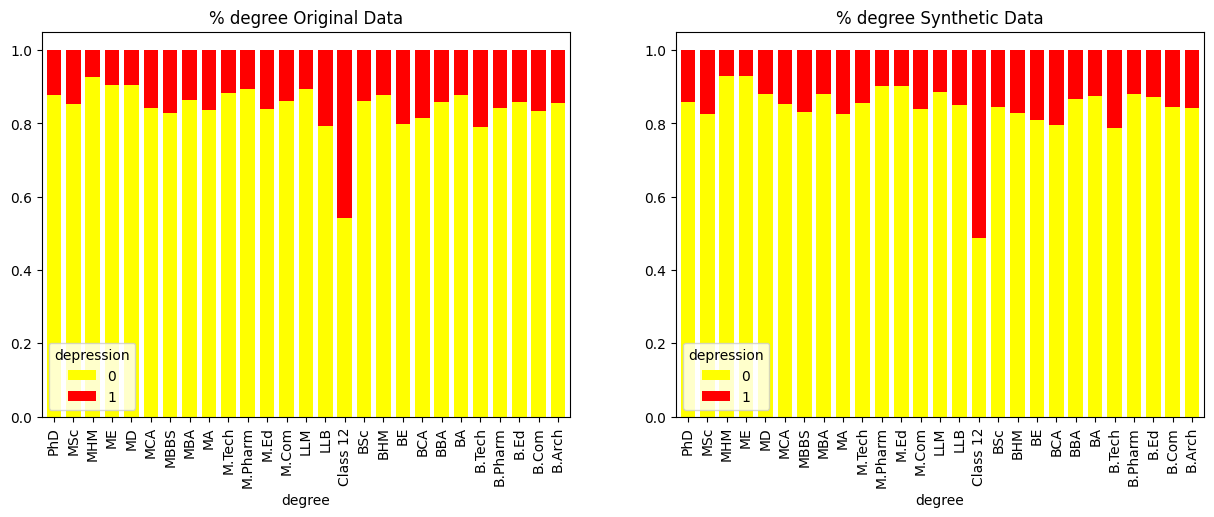

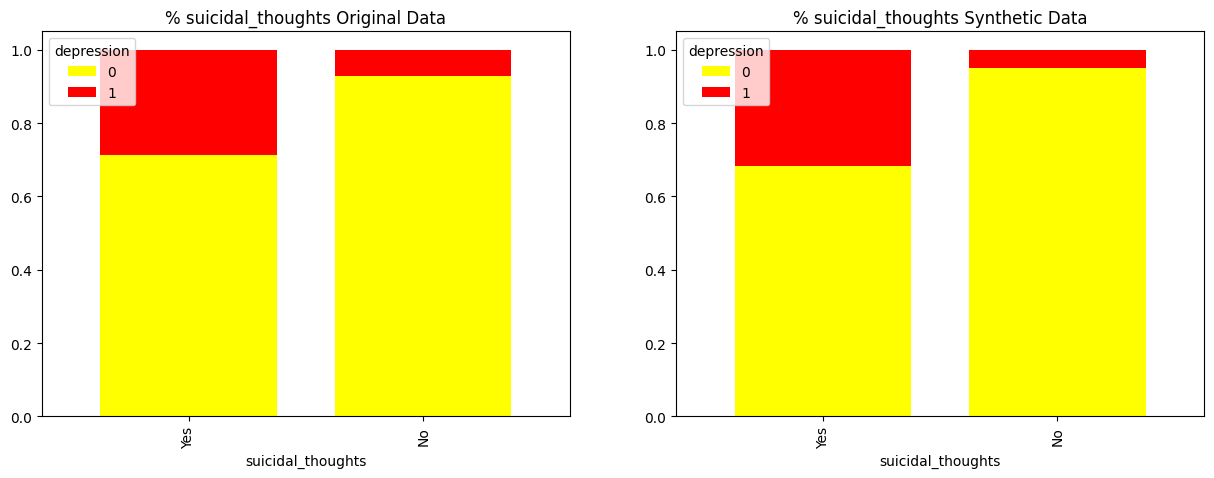

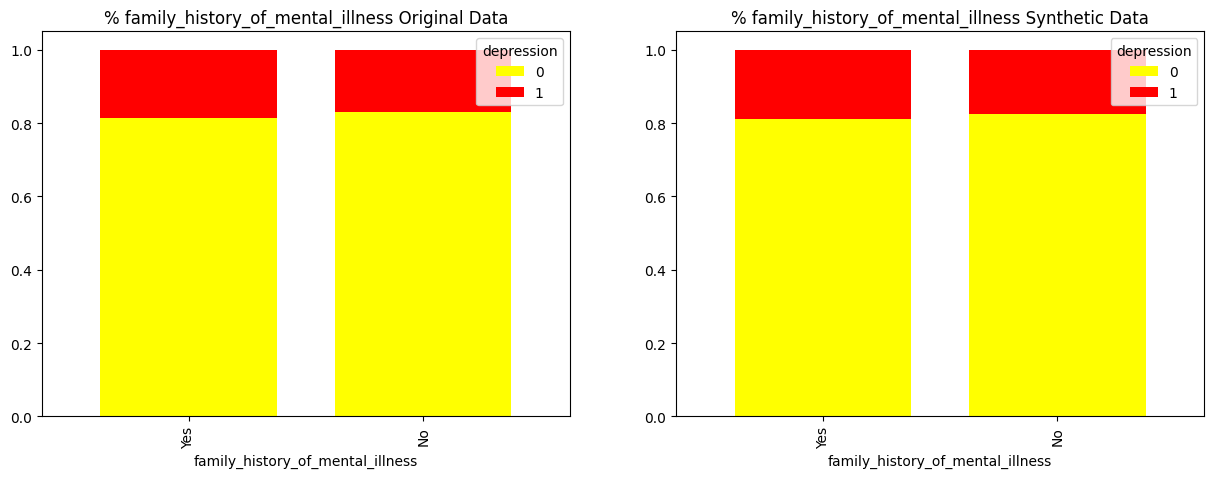

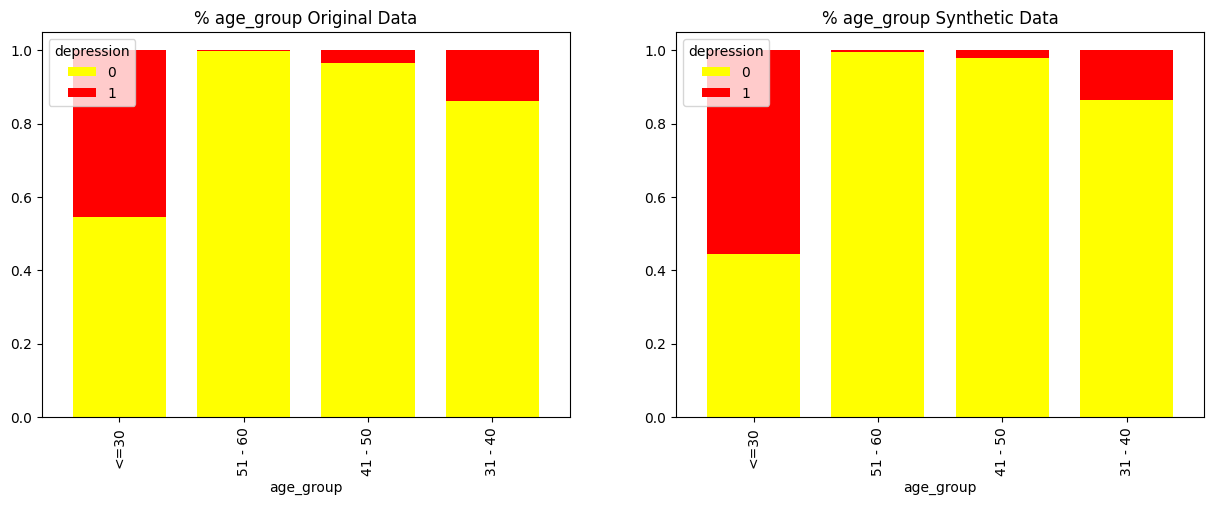

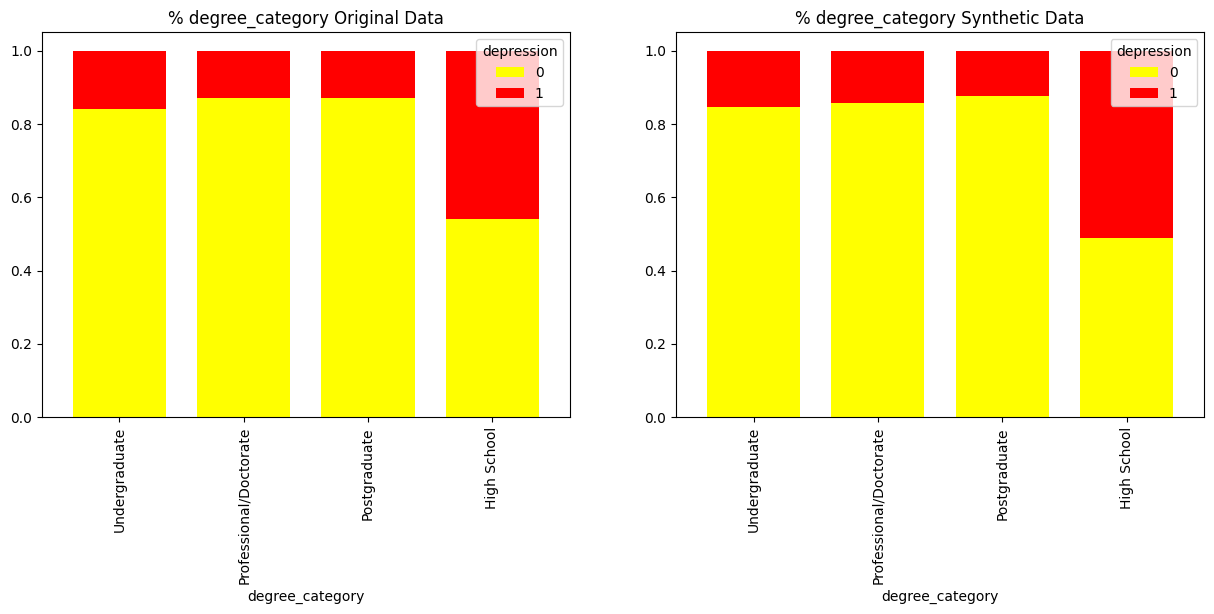

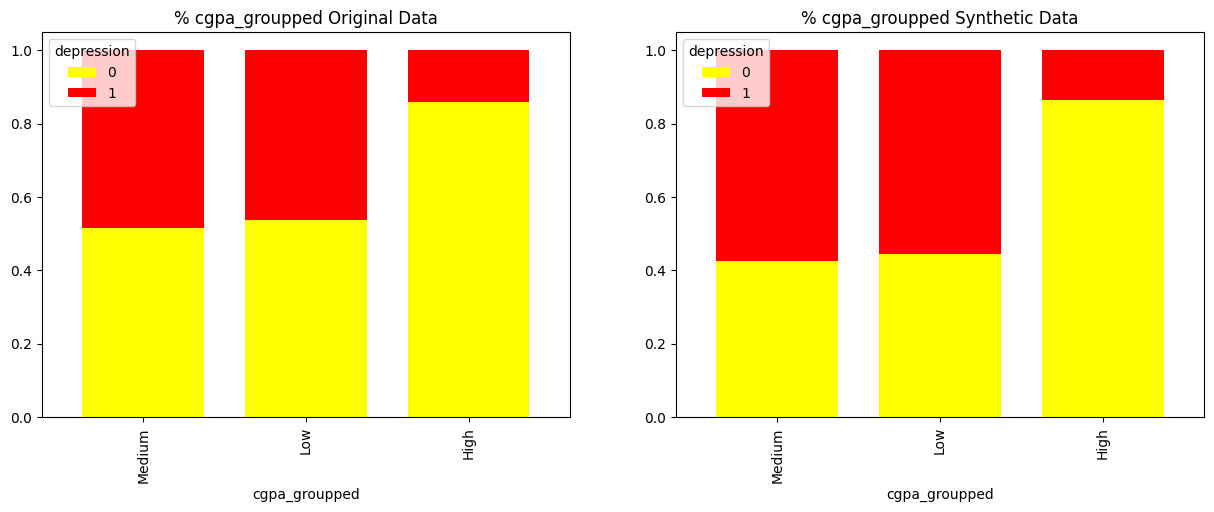

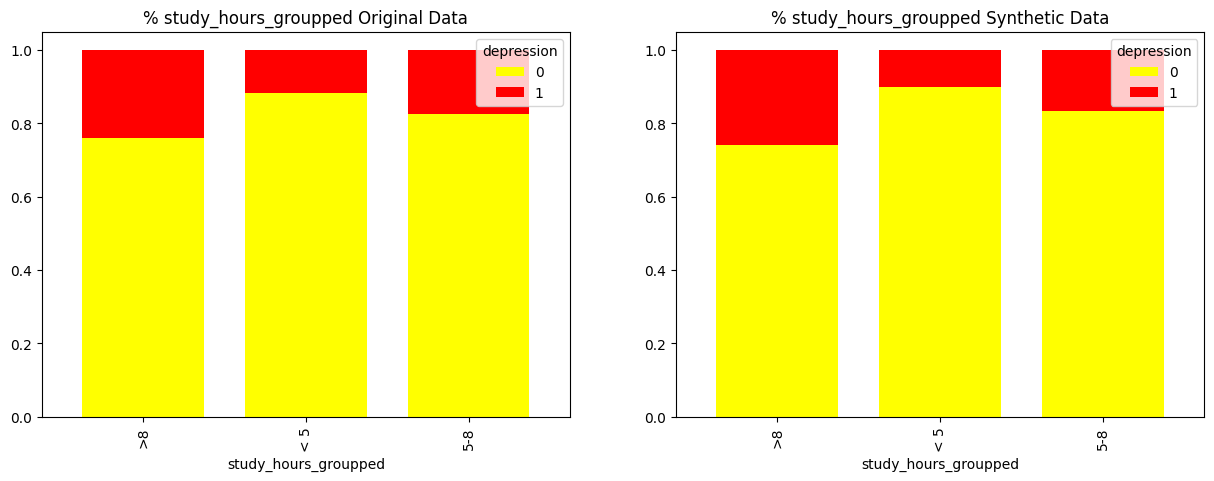

In [58]:
for col in categorical_var:
    stacked_chart(col)

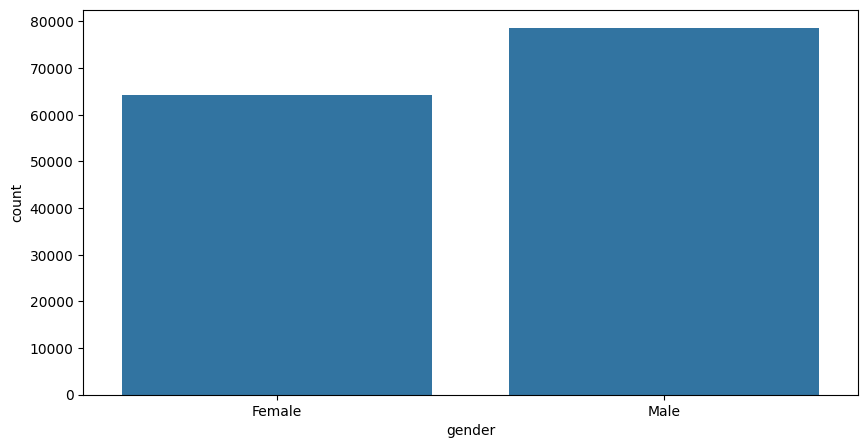

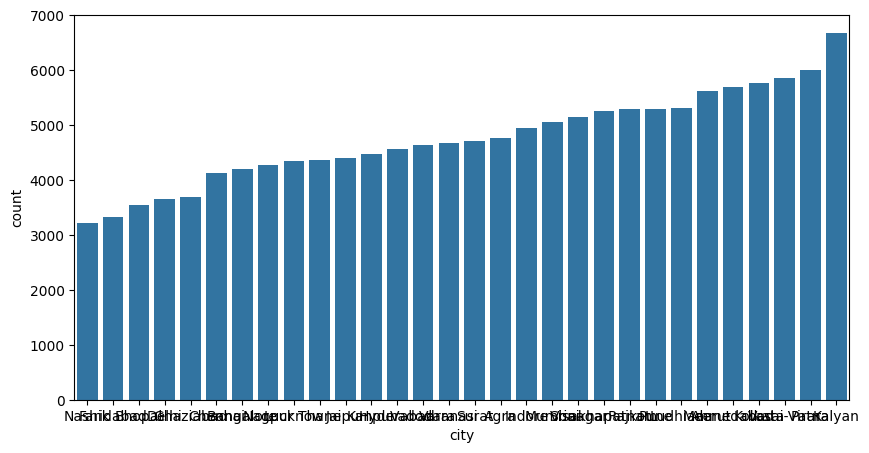

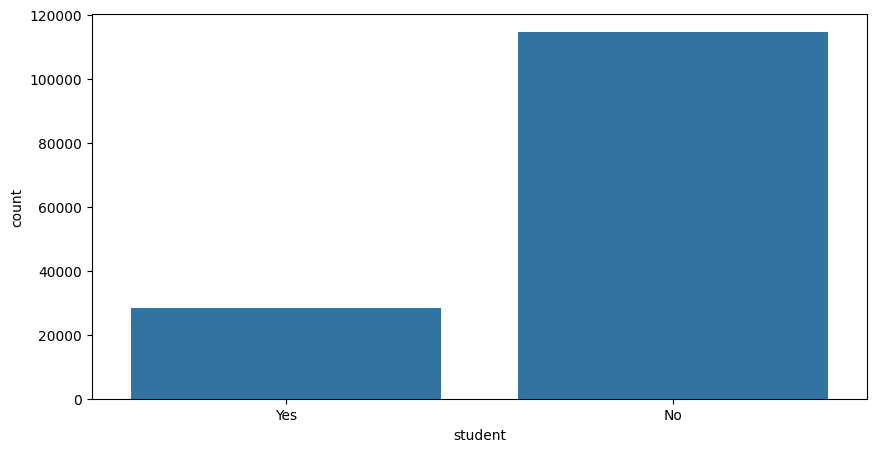

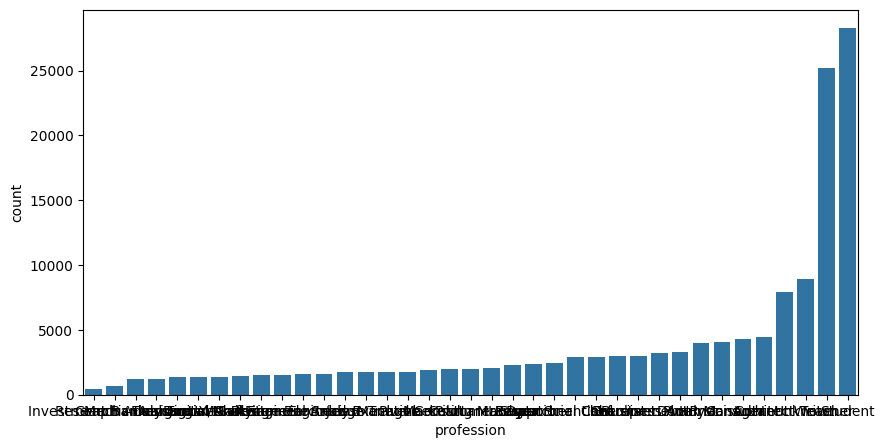

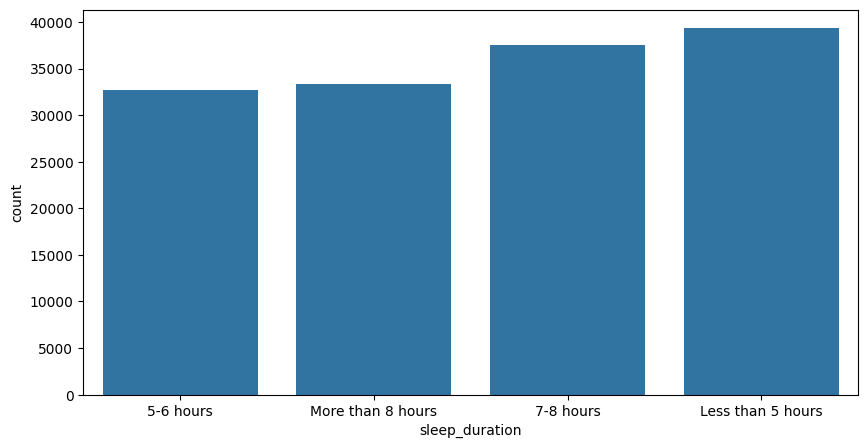

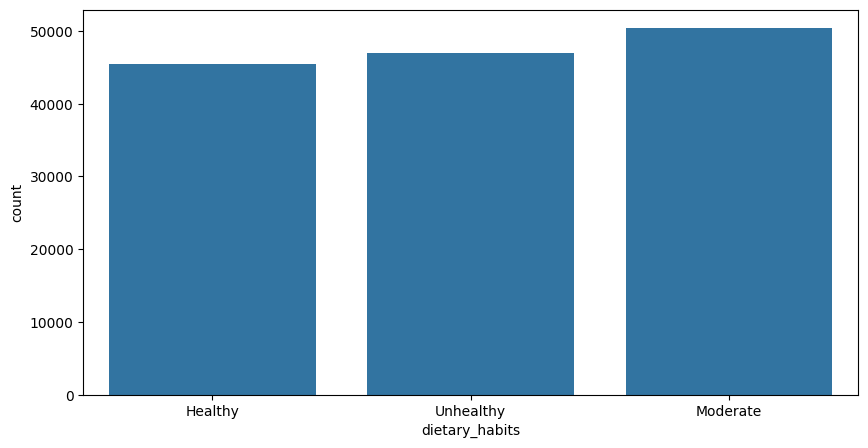

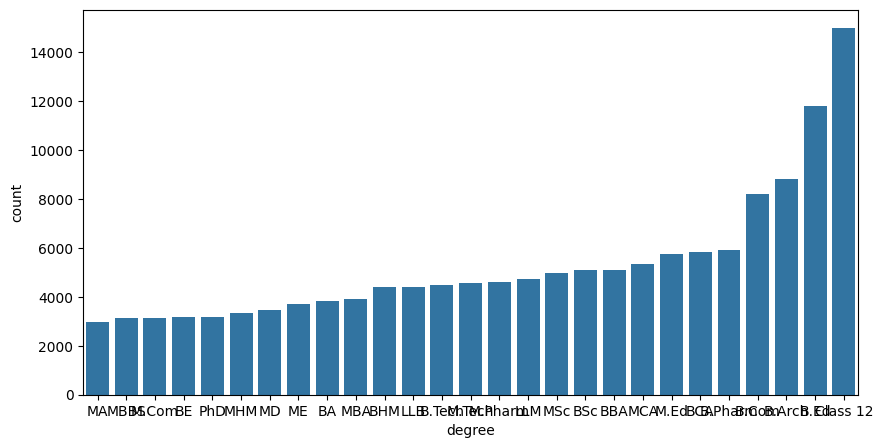

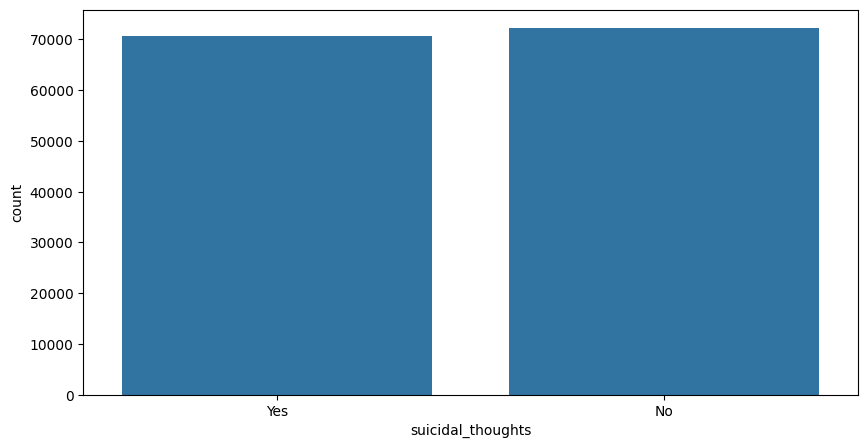

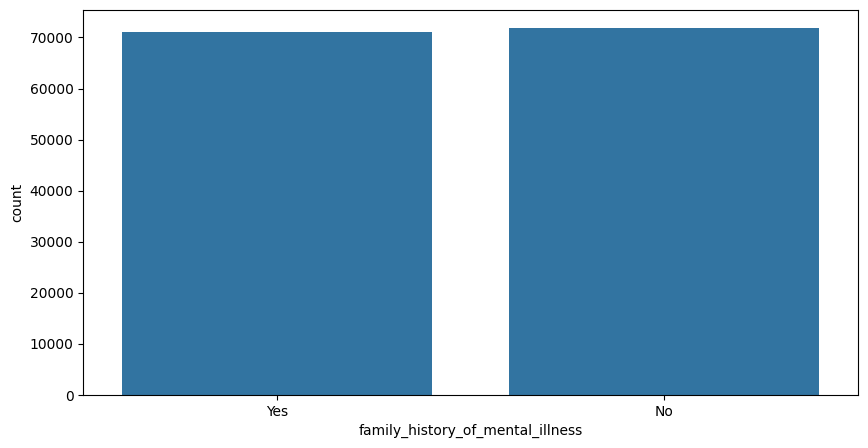

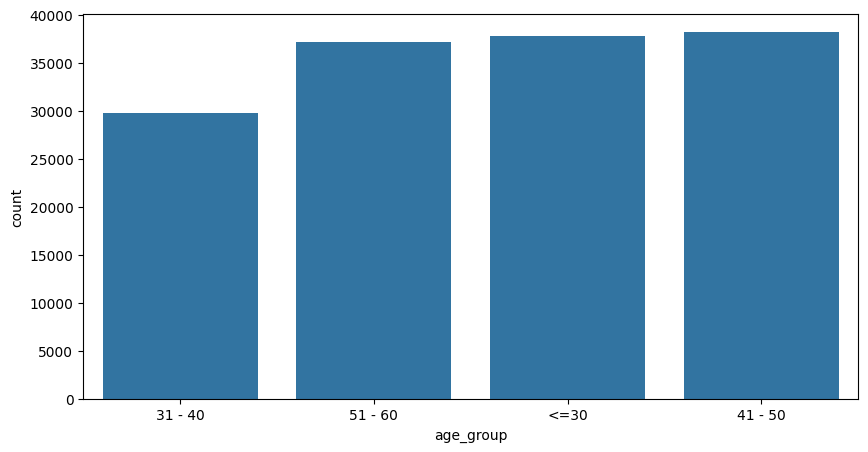

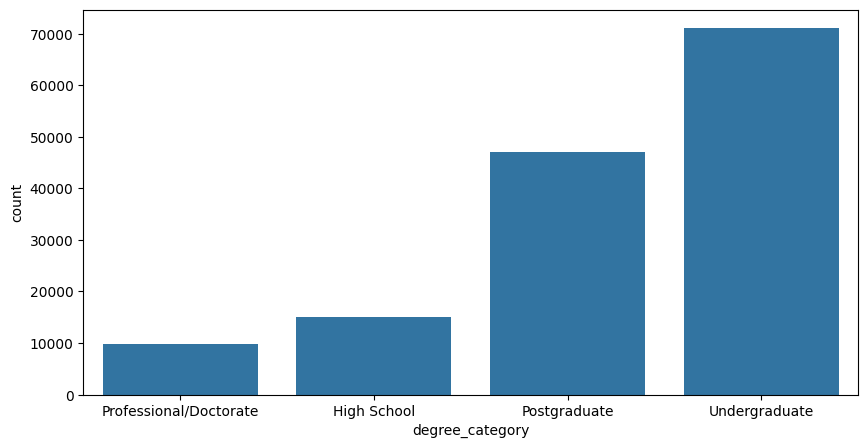

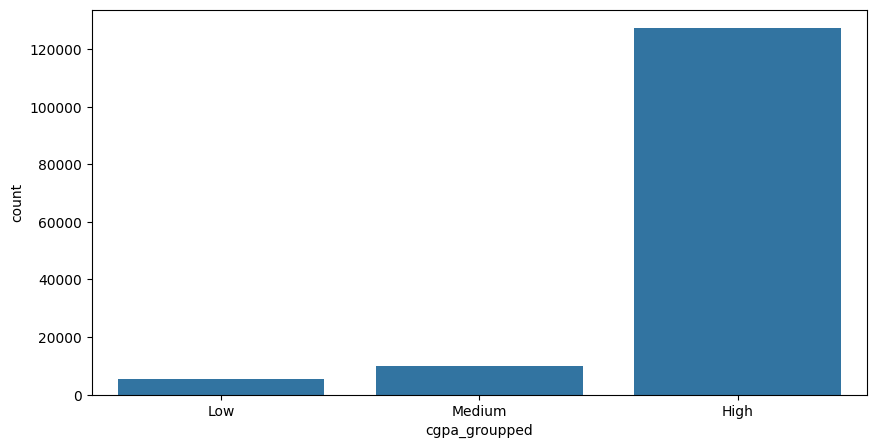

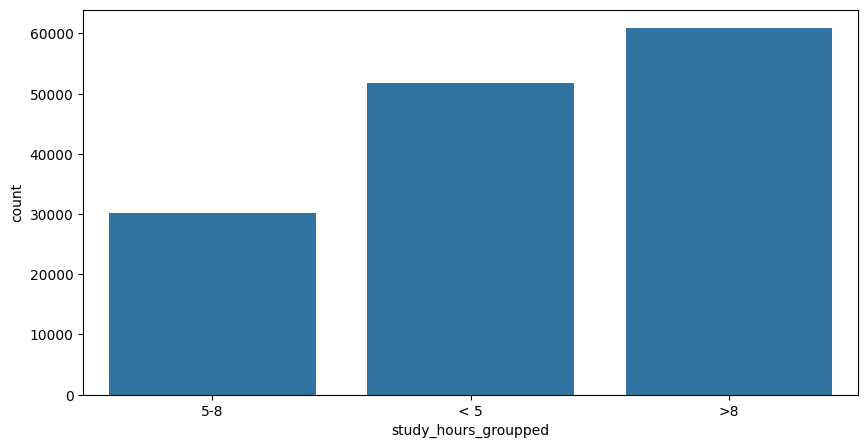

In [59]:
for col in categorical_var:  
        plt.figure(figsize=(10,5))
        sns.barplot(data = mental_health[col].value_counts().reset_index().sort_values('count'),
                   x=col,
                   y='count')
        plt.show()

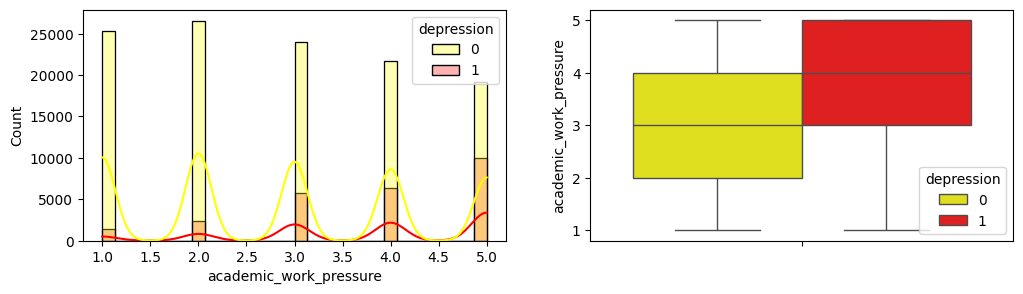

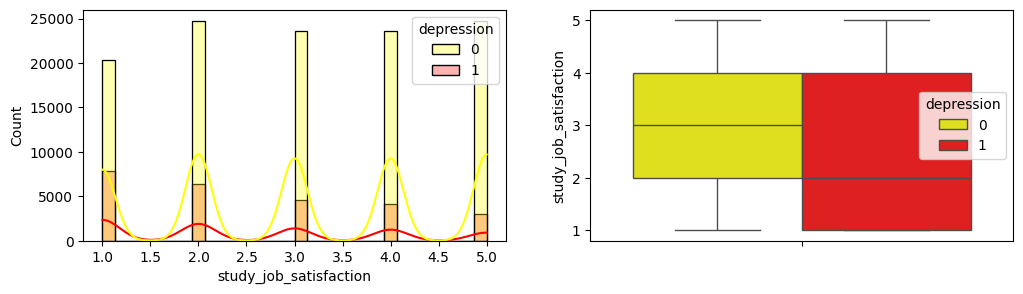

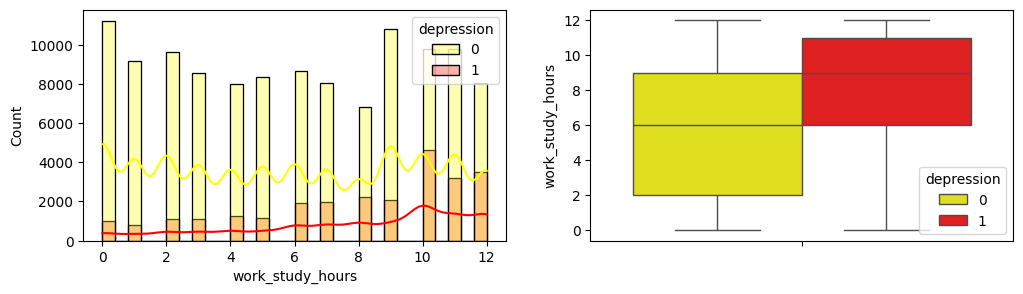

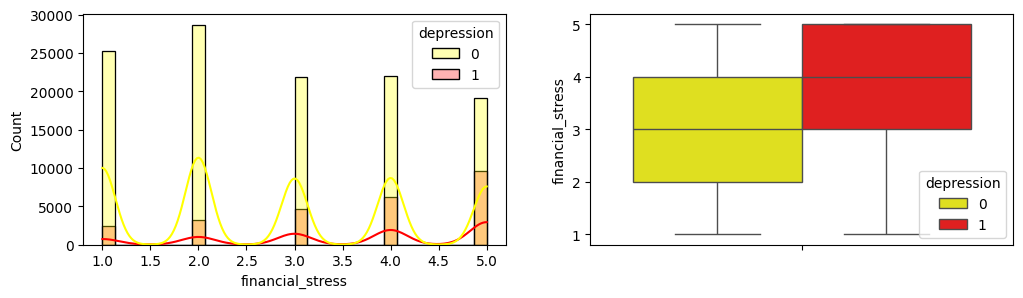

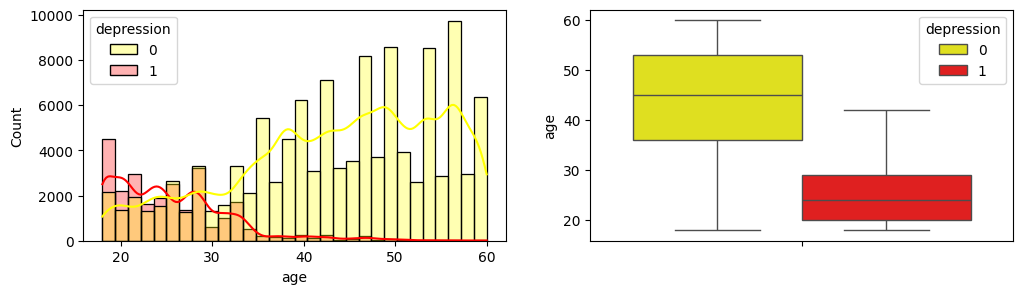

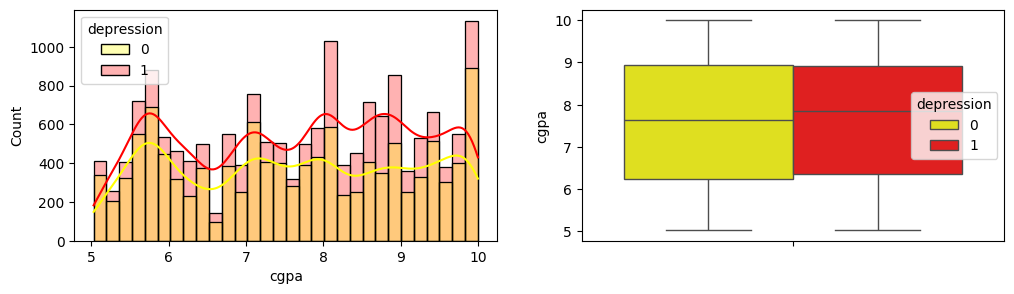

In [60]:
for num_var in discrete_var+continous_var:    
   
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))   
    
    # Histograms    
    sns.histplot(data=mental_health, 
                      x=num_var,
                      bins = 30,
                      hue = 'depression',
                      palette=col_palette,
                      kde=True,
                      alpha=0.3,
                      ax=ax[0]                          
                ) 
    # Mean vertical line
   # ax[0].axvline(np.mean(mental_health_viz[num_var]), color="red")   
    
    # Boxplots
    sns.boxplot(data=mental_health, 
                     y=num_var,
                     hue = 'depression',
                     palette=col_palette,
                     showfliers=False,
                     ax=ax[1]
                   );

***
# More EDA
***

In [61]:
mental_health_subset = mental_health.copy().drop(columns=['name', 'Source']) 

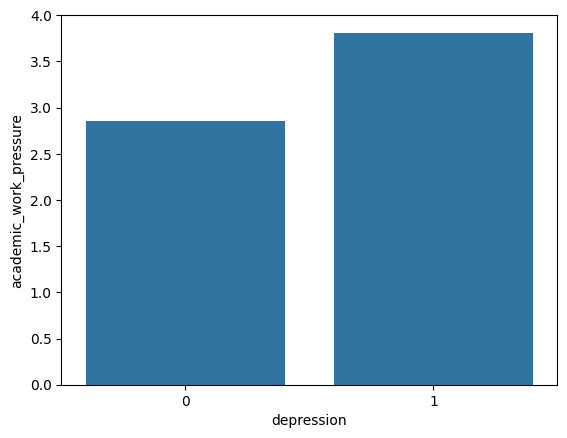

In [62]:
sns.barplot(data=mental_health_subset[['depression', 'academic_work_pressure']].groupby('depression').mean().reset_index(),
           x='depression',
           y='academic_work_pressure');

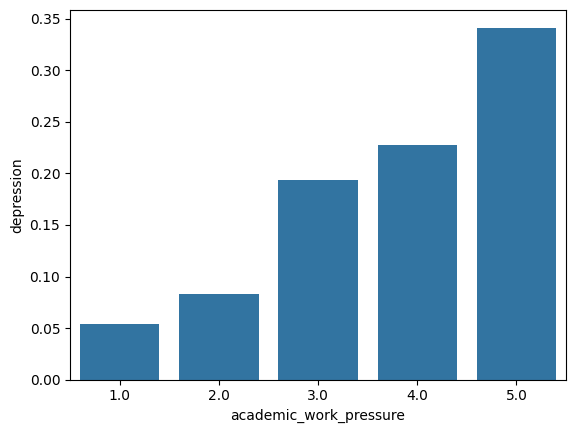

In [63]:
#pd.set_option('display.max_rows', None)
sns.barplot(data=mental_health_subset[['depression', 'academic_work_pressure']].groupby('academic_work_pressure').mean().reset_index().sort_values('depression', ascending=False),
            x='academic_work_pressure',
            y='depression');

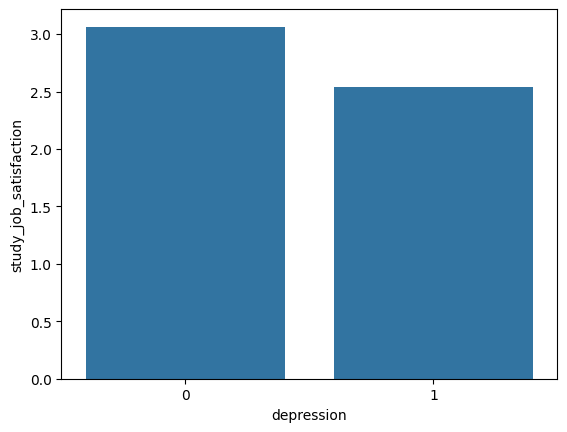

In [64]:
sns.barplot(data=mental_health_subset[['depression', 'study_job_satisfaction']].groupby('depression').mean().reset_index(),
           x='depression',
           y='study_job_satisfaction');

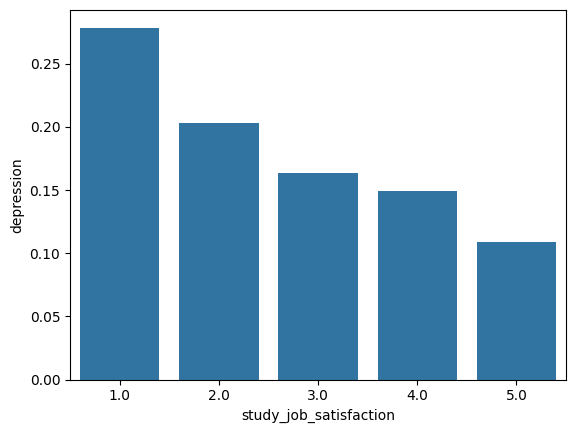

In [65]:
#pd.set_option('display.max_rows', None)
sns.barplot(data=mental_health_subset[['depression', 'study_job_satisfaction']].groupby('study_job_satisfaction').mean().reset_index().sort_values('depression', ascending=False),
            x='study_job_satisfaction',
            y='depression');

In [66]:
### Depressed people are more likely to have an negative perspective about everything and also, they are less productive due to lack of engagement and they have some cognitive losses, such as: Attention, Focus, Working memory, etc. 

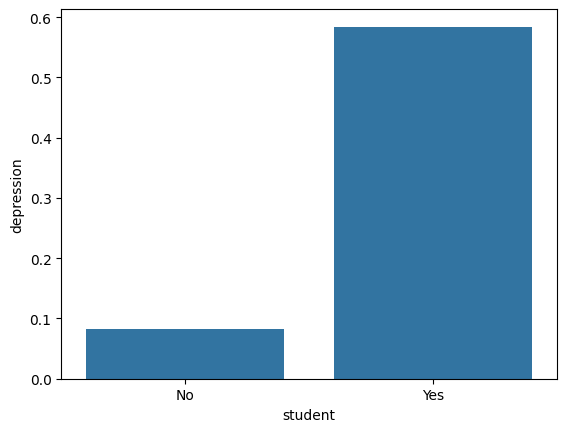

In [67]:
sns.barplot(data=mental_health_subset[['depression', 'student']].groupby('student').mean().reset_index(),
           x='student',
           y='depression');

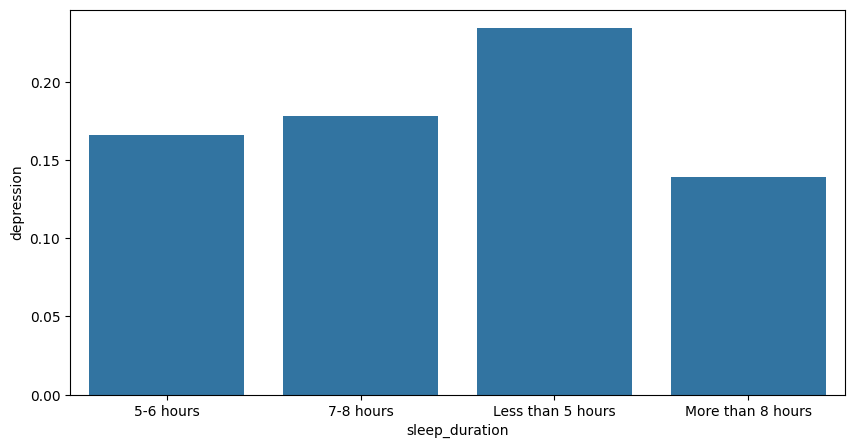

In [68]:
plt.figure(figsize=(10,5))
sns.barplot(data=mental_health_subset[['depression', 'sleep_duration']].groupby('sleep_duration').mean().reset_index(),
           x='sleep_duration',
           y='depression');

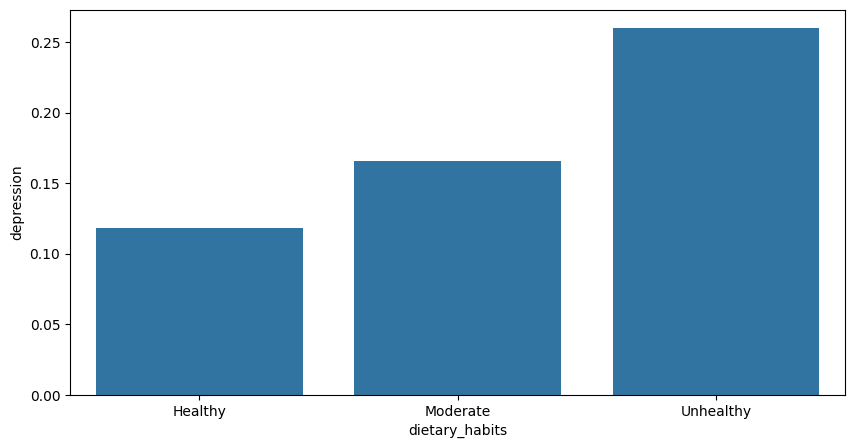

In [69]:
plt.figure(figsize=(10,5))
sns.barplot(data=mental_health_subset[['depression', 'dietary_habits']].groupby('dietary_habits').mean().reset_index(),
           x='dietary_habits',
           y='depression');

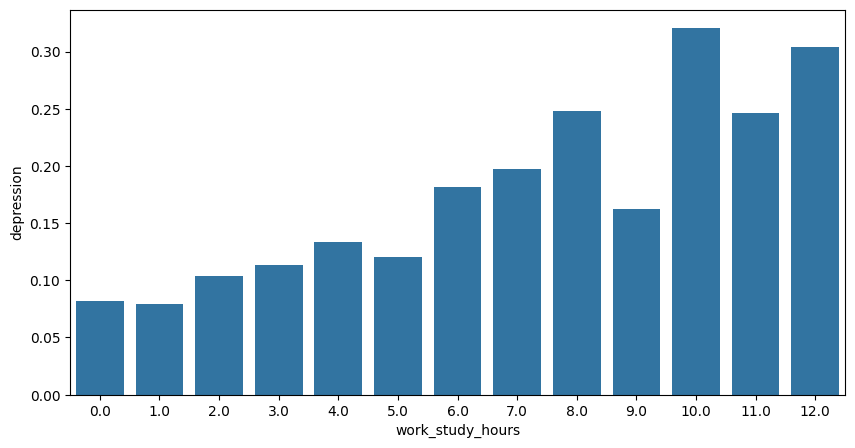

In [70]:
plt.figure(figsize=(10,5))
sns.barplot(data=mental_health_subset[['depression', 'work_study_hours']].groupby('work_study_hours').mean().reset_index(),
           x='work_study_hours',
           y='depression');

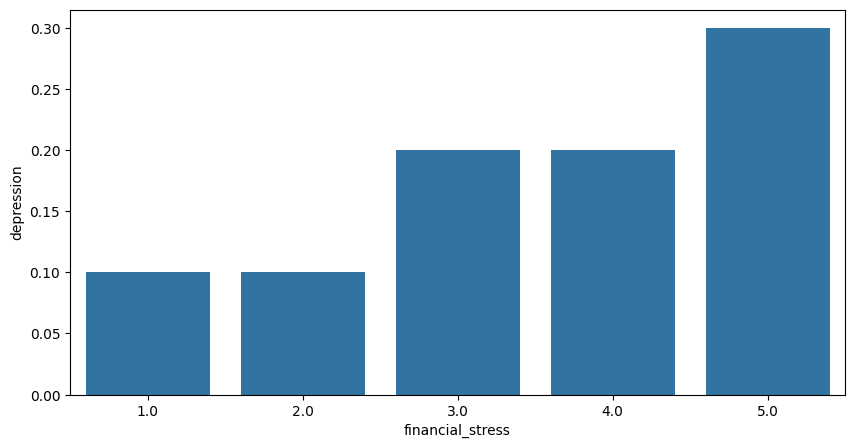

In [71]:
plt.figure(figsize=(10,5))
sns.barplot(data=mental_health_subset[['depression', 'financial_stress']].groupby('financial_stress').mean().reset_index().round(1),
           x='financial_stress',
           y='depression');

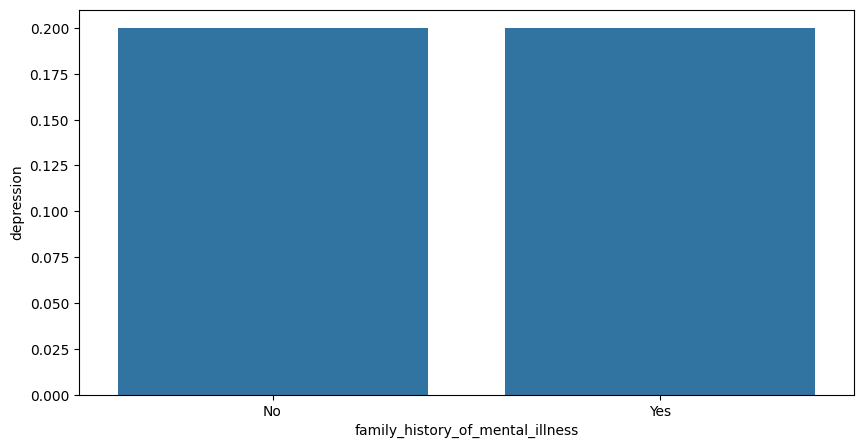

In [72]:
plt.figure(figsize=(10,5))
sns.barplot(data=mental_health_subset[['depression', 'family_history_of_mental_illness']].groupby('family_history_of_mental_illness').mean().reset_index().round(1),
           x='family_history_of_mental_illness',
           y='depression');

***
## Analyzing Gender
***


In [73]:
mental_health_original['gender'].value_counts(normalize=True)

gender
Male      0.521518
Female    0.478482
Name: proportion, dtype: float64

In [74]:
mental_health_original[['gender', 'depression']].groupby('gender').mean().reset_index()

,gender,depression
0,Female,0.174980
1,Male,0.180795


In [75]:
from scipy.stats import chi2_contingency

def cont_tb(var1, var2):
    return pd.crosstab(mental_health_original[var1], mental_health_original[var2])    

In [76]:
ct_gender = cont_tb('gender','depression')

In [77]:
def chi_tb(cont_tb):
    chi2, p, dof, expected = chi2_contingency(cont_tb)
    df= pd.DataFrame({"Metric": ["Chi-square statistic (χ²)", "p-value", "Degrees of Freedom (dof)"],
             "Value": [chi2, p, dof]})
    return df

In [78]:
chi_tb(ct_gender)

,Metric,Value
0,Chi-square statistic (χ²),0.110360
1,p-value,0.739735
2,Degrees of Freedom (dof),1.000000



Considering the Significance Level of 0.05 and the p-value of 0.739735

There is no statistical siginificance association between `Gender` and `Depression`

***
## Analyzing Age
***

In [79]:
mental_health_original['age_group'].value_counts(normalize=True)

age_group
<=30       0.300078
41 - 50    0.239045
31 - 40    0.235133
51 - 60    0.225743
Name: proportion, dtype: float64

In [80]:
mental_health_original[['age_group', 'depression']].groupby('age_group').mean().reset_index()

,age_group,depression
0,31 - 40,0.139767
1,41 - 50,0.034370
2,51 - 60,0.001733
3,<=30,0.455020


In [81]:
ct_age = cont_tb('age_group','depression')

In [82]:
chi_tb(ct_age)

,Metric,Value
0,Chi-square statistic (χ²),6.169188e+02
1,p-value,2.165435e-133
2,Degrees of Freedom (dof),3.000000e+00


In [83]:
def chi_post_hoc(var1, var2):
    """
    Perform pairwise Chi-square tests and compute odds ratios for post-hoc analysis.

    Args:
    - var1: Independent categorical variable
    - var2: Dependent binary variable
    - data: DataFrame containing the variables

    Returns:
    - DataFrame with pairwise comparisons, Chi-square statistics, p-values, Bonferroni corrected p-values, significance, and odds ratios.
    """
    # Convert to DataFrame
    df = pd.DataFrame(mental_health_original)

    # Get unique categories for the independent variable
    categories = df[var1].unique()

    # Generate all pairwise combinations of categories
    category_pairs = list(combinations(categories, 2))

    # Initialize a list to store results
    post_hoc_results = []

    # Perform pairwise Chi-square tests
    for pair in category_pairs:
        # Filter data for the pair of categories
        filtered_data = df[df[var1].isin(pair)]

        # Create contingency table
        contingency_table = pd.crosstab(filtered_data[var1], filtered_data[var2])

        # Perform Chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Calculate odds ratio
        if contingency_table.shape == (2, 2):  # Ensure 2x2 table for odds ratio calculation
            (a, b), (c, d) = contingency_table.values
            odds_ratio = (a / b) / (c / d)
        else:
            odds_ratio = None

        # Store results
        post_hoc_results.append({
            "Comparison": f"{pair[0]} vs {pair[1]}",
            "Chi-square Statistic (χ²)": chi2,
            "p-value": p,
            "Odds Ratio": odds_ratio
        })

    # Convert results to a DataFrame
    post_hoc_df = pd.DataFrame(post_hoc_results)

    # Apply Bonferroni Correction
    alpha = 0.05
    post_hoc_df['Bonferroni Corrected p-value'] = alpha / len(category_pairs)

    # Determine significance
    post_hoc_df['Significant'] = post_hoc_df['p-value'] < post_hoc_df['Bonferroni Corrected p-value']

    # Display the results
    return post_hoc_df


In [84]:
pd.set_option('display.max_rows', None)
chi_post_hoc('age_group','depression')

,Comparison,Chi-square Statistic (χ²),p-value,Odds Ratio,Bonferroni Corrected p-value,Significant
0,31 - 40 vs 51 - 60,81.728610,1.561171e-19,0.010685,0.008333,True
1,31 - 40 vs 41 - 50,41.212748,1.365292e-10,0.219068,0.008333,True
2,31 - 40 vs <=30,153.347099,3.216736e-35,5.138784,0.008333,True
3,51 - 60 vs 41 - 50,15.641806,7.654351e-05,0.048776,0.008333,True
4,51 - 60 vs <=30,348.936960,7.221588e-78,480.918660,0.008333,True
5,41 - 50 vs <=30,304.245037,3.916895e-68,23.457507,0.008333,True


***

## Analyzing Student
***

In [85]:
mental_health_original['student'].value_counts(normalize=True)

student
No     0.803599
Yes    0.196401
Name: proportion, dtype: float64

In [86]:
mental_health_original[['student', 'depression']].groupby('student').mean().reset_index()

,student,depression
0,No,0.098832
1,Yes,0.501992


In [87]:
ct_student = cont_tb('student','depression')

In [88]:
def odds_ratio(var1, var2, cat1, cat2):
    # Create a contingency table for Gender vs Depression
    contingency_table = pd.crosstab(mental_health_original[var1], mental_health_original[var2])

    a = contingency_table.loc[cat1, 1]   
    b = contingency_table.loc[cat1, 0]   
    c = contingency_table.loc[cat2, 1]  
    d = contingency_table.loc[cat2, 0]  

    # Calculate the odds ratio (OR)
    odds_ratio = (a * d) / (b * c)

    # Display the odds ratio
    print(f"Odds Ratio (OR) for {contingency_table.index.name} and Depression: {odds_ratio:.4f}")


In [89]:
odds_ratio('student', 'depression', 'Yes', 'No')

Odds Ratio (OR) for student and Depression: 9.1912


***
## Suicidal Thoughts
***

In [90]:
mental_health_original['suicidal_thoughts'].value_counts(normalize=True)

suicidal_thoughts
No     0.511346
Yes    0.488654
Name: proportion, dtype: float64

In [91]:
mental_health_original[['suicidal_thoughts', 'depression']].groupby('suicidal_thoughts').mean().reset_index()

,suicidal_thoughts,depression
0,No,0.072686
1,Yes,0.288231


In [92]:
ct_suic_thoughts = cont_tb('suicidal_thoughts','depression')

In [93]:
chi_tb(ct_suic_thoughts)

,Metric,Value
0,Chi-square statistic (χ²),2.013154e+02
1,p-value,1.078419e-45
2,Degrees of Freedom (dof),1.000000e+00


In [94]:
odds_ratio('suicidal_thoughts', 'depression', 'Yes', 'No')

Odds Ratio (OR) for suicidal_thoughts and Depression: 5.1663


***
## Dietary Habits
***

In [95]:
mental_health_original['dietary_habits'].value_counts(normalize=True)

dietary_habits
Unhealthy    0.345070
Healthy      0.329421
Moderate     0.325509
Name: proportion, dtype: float64

In [96]:
mental_health_original[['dietary_habits', 'depression']].groupby('dietary_habits').mean().reset_index()

,dietary_habits,depression
0,Healthy,0.130641
1,Moderate,0.169471
2,Unhealthy,0.231293


In [97]:
ct_diet_habits = cont_tb('dietary_habits','depression')

In [98]:
chi_tb(ct_diet_habits)

,Metric,Value
0,Chi-square statistic (χ²),3.043899e+01
1,p-value,2.456169e-07
2,Degrees of Freedom (dof),2.000000e+00


In [99]:
chi_post_hoc('dietary_habits', 'depression')

,Comparison,Chi-square Statistic (χ²),p-value,Odds Ratio,Bonferroni Corrected p-value,Significant
0,Moderate vs Unhealthy,9.796976,1.747991e-03,1.474550,0.016667,True
1,Moderate vs Healthy,4.650471,3.104502e-02,1.357874,0.016667,False
2,Unhealthy vs Healthy,28.624119,8.788071e-08,2.002253,0.016667,True


***
## Family History Illness
***

In [100]:
mental_health_original['family_history_of_mental_illness'].value_counts(normalize=True)

family_history_of_mental_illness
No     0.512911
Yes    0.487089
Name: proportion, dtype: float64

In [101]:
mental_health_original[['family_history_of_mental_illness', 'depression']].groupby('family_history_of_mental_illness').mean().reset_index()

,family_history_of_mental_illness,depression
0,No,0.170862
1,Yes,0.185542


In [102]:
ct_fam_illness = cont_tb('family_history_of_mental_illness','depression')

In [103]:
chi_tb(ct_fam_illness)

,Metric,Value
0,Chi-square statistic (χ²),0.842854
1,p-value,0.358582
2,Degrees of Freedom (dof),1.000000


***
## Sleep Duration
***

In [104]:
mental_health_original['sleep_duration'].value_counts(normalize=True)

sleep_duration
7-8 hours            0.257433
Less than 5 hours    0.253521
5-6 hours            0.245696
More than 8 hours    0.243349
Name: proportion, dtype: float64

In [105]:
mental_health_original[['sleep_duration', 'depression']].groupby('sleep_duration').mean().reset_index()

,sleep_duration,depression
0,5-6 hours,0.173567
1,7-8 hours,0.173252
2,Less than 5 hours,0.217593
3,More than 8 hours,0.146302


In [106]:
ct_sleep_duration = cont_tb('sleep_duration','depression')

In [107]:
chi_tb(ct_sleep_duration)

,Metric,Value
0,Chi-square statistic (χ²),11.398765
1,p-value,0.009754
2,Degrees of Freedom (dof),3.000000


In [108]:
chi_post_hoc('sleep_duration', 'depression')

,Comparison,Chi-square Statistic (χ²),p-value,Odds Ratio,Bonferroni Corrected p-value,Significant
0,7-8 hours vs 5-6 hours,0.000000,1.000000,0.997808,0.008333,False
1,7-8 hours vs More than 8 hours,1.532013,0.215811,0.817788,0.008333,False
2,7-8 hours vs Less than 5 hours,3.807745,0.051016,1.327105,0.008333,False
3,5-6 hours vs More than 8 hours,1.531473,0.215891,0.815995,0.008333,False
4,5-6 hours vs Less than 5 hours,3.649351,0.056091,1.324195,0.008333,False
5,More than 8 hours vs Less than 5 hours,10.330818,0.001308,0.616220,0.008333,True


***
## Degree
***

In [109]:
mental_health_original['degree_category'].value_counts(normalize=True)

degree_category
Undergraduate             0.433881
Postgraduate              0.368545
High School               0.107590
Professional/Doctorate    0.089984
Name: proportion, dtype: float64

In [110]:
mental_health_original[['degree_category', 'depression']].groupby('degree_category').mean().reset_index()

,degree_category,depression
0,High School,0.458182
1,Postgraduate,0.128450
2,Professional/Doctorate,0.130435
3,Undergraduate,0.160505


In [111]:
ct_degree_cat = cont_tb('degree_category','depression')

In [112]:
chi_tb(ct_degree_cat)

,Metric,Value
0,Chi-square statistic (χ²),1.692176e+02
1,p-value,1.877497e-36
2,Degrees of Freedom (dof),3.000000e+00


In [113]:
chi_post_hoc('degree_category', 'depression')

,Comparison,Chi-square Statistic (χ²),p-value,Odds Ratio,Bonferroni Corrected p-value,Significant
0,Postgraduate vs Undergraduate,3.949254,4.689215e-02,1.297263,0.008333,False
1,Postgraduate vs Professional/Doctorate,0.000000,1.000000e+00,1.017769,0.008333,False
2,Postgraduate vs High School,141.031803,1.583390e-32,0.174284,0.008333,True
3,Undergraduate vs Professional/Doctorate,1.093587,2.956778e-01,1.274615,0.008333,False
4,Undergraduate vs High School,112.188145,3.249616e-26,0.226092,0.008333,True
5,Professional/Doctorate vs High School,61.494276,4.440322e-15,0.177381,0.008333,True


***
## Work/Study Hours
***

In [114]:
mental_health_original['study_hours_groupped'][mental_health_original['student'] == 'Yes'].value_counts(normalize=True)

study_hours_groupped
>8     0.434263
< 5    0.348606
5-8    0.217131
Name: proportion, dtype: float64

In [115]:
mental_health_original[['study_hours_groupped','depression']][mental_health_original['student'] == 'Yes'].groupby('study_hours_groupped').mean().reset_index()

,study_hours_groupped,depression
0,5-8,0.568807
1,< 5,0.354286
2,>8,0.587156


In [116]:
ct_study = cont_tb('study_hours_groupped','depression')

In [117]:
chi_tb(ct_study)

,Metric,Value
0,Chi-square statistic (χ²),5.106256e+01
1,p-value,8.164044e-12
2,Degrees of Freedom (dof),2.000000e+00


In [118]:
chi_post_hoc('study_hours_groupped', 'depression')

,Comparison,Chi-square Statistic (χ²),p-value,Odds Ratio,Bonferroni Corrected p-value,Significant
0,5-8 vs < 5,8.959640,2.760092e-03,0.636227,0.016667,True
1,5-8 vs >8,9.392402,2.178866e-03,1.511462,0.016667,True
2,< 5 vs >8,49.779743,1.720107e-12,2.375666,0.016667,True


***
# Predictive Model
***

In [119]:
cat_cols = ['city', 'student','profession', 'sleep_duration', 'sleep_duration', 'dietary_habits',\
            'suicidal_thoughts', 'family_history_of_mental_illness', 'depression', 'degree_category']

cont_cols = ['age', 'academic_work_pressure', 'study_job_satisfaction', 'cgpa', 'work_study_hours', 'financial_stress',]

In [120]:
mental_health_enc = mental_health_subset.copy()

enc = LabelEncoder()

for col in cat_cols:
    mental_health_enc[col] = enc.fit_transform(mental_health_enc[col])

In [121]:
pd.set_option('display.max_rows', 5)
mental_health_enc.drop(columns=['degree', 'age_group'], inplace=True)

In [122]:
from sklearn.model_selection import train_test_split

X = mental_health_enc.drop(columns='depression')

y = mental_health_enc['depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [123]:
mental_health_enc.fillna(0, inplace=True)

## Logistic Regression Baseline - Accuracy: 94%

Confusion Matrix:
[[22541   819]
 [ 1022  4196]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23360
           1       0.84      0.80      0.82      5218

    accuracy                           0.94     28578
   macro avg       0.90      0.88      0.89     28578
weighted avg       0.93      0.94      0.94     28578


ROC-AUC Score:
0.9734913425340104


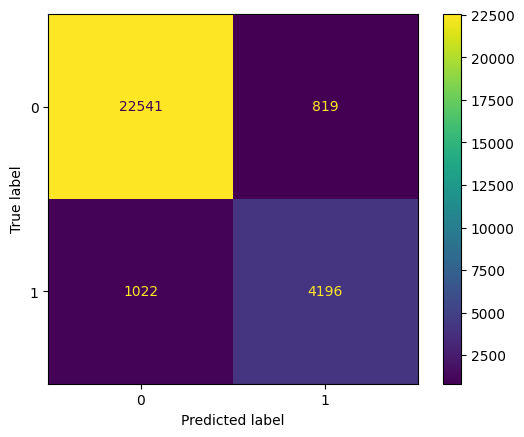

In [124]:
df = pd.DataFrame(mental_health_enc)

# Define independent variables (X) and dependent variable (y)
X = df[['age', 'academic_work_pressure', 'cgpa', 'study_job_satisfaction',
        'suicidal_thoughts', 'work_study_hours', 'financial_stress', 'family_history_of_mental_illness']]
y = df['depression']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

## XGBoost Baseline - Accuracy: 94%

Confusion Matrix:
[[22546   814]
 [  970  4248]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23360
           1       0.84      0.81      0.83      5218

    accuracy                           0.94     28578
   macro avg       0.90      0.89      0.89     28578
weighted avg       0.94      0.94      0.94     28578



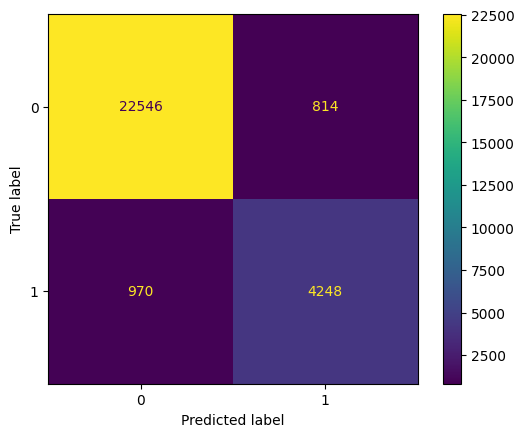

In [125]:
# Initialize XGBoost model with default parameters
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

# Evaluate the model


cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
#print("\nROC-AUC Score:")
#print(roc_auc_score(y_test, y_pred_proba))


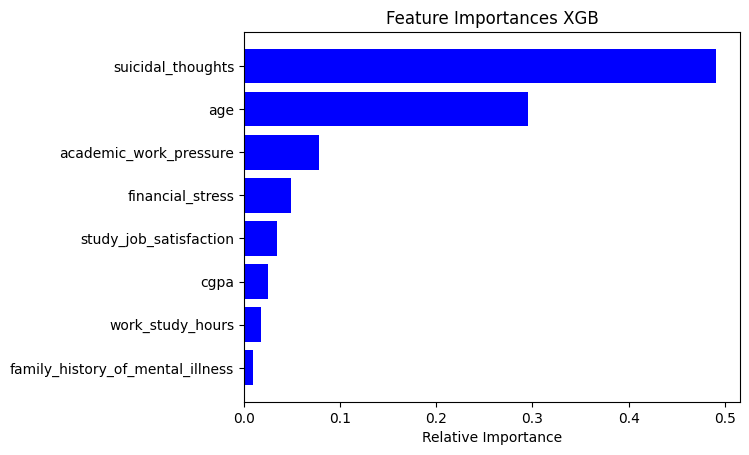

In [126]:
importances = xgb.feature_importances_
indices = np.argsort(importances)
features = X.columns

plt.title('Feature Importances XGB')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Random Forest Baseline - Accuracy: 93%

In [127]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Confusion Matrix:
[[22417   943]
 [ 1081  4137]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     23360
           1       0.81      0.79      0.80      5218

    accuracy                           0.93     28578
   macro avg       0.88      0.88      0.88     28578
weighted avg       0.93      0.93      0.93     28578



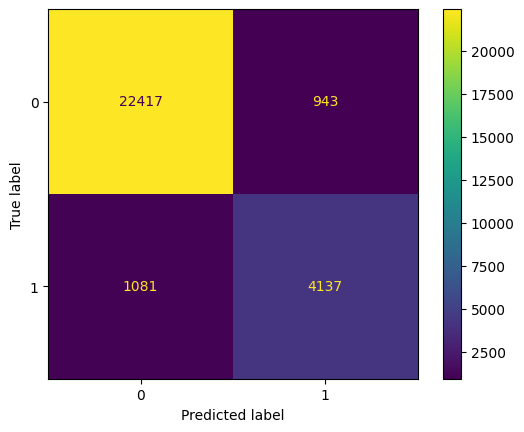

In [128]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
#print("\nROC-AUC Score:")
#print(roc_auc_score(y_test, y_pred_proba))

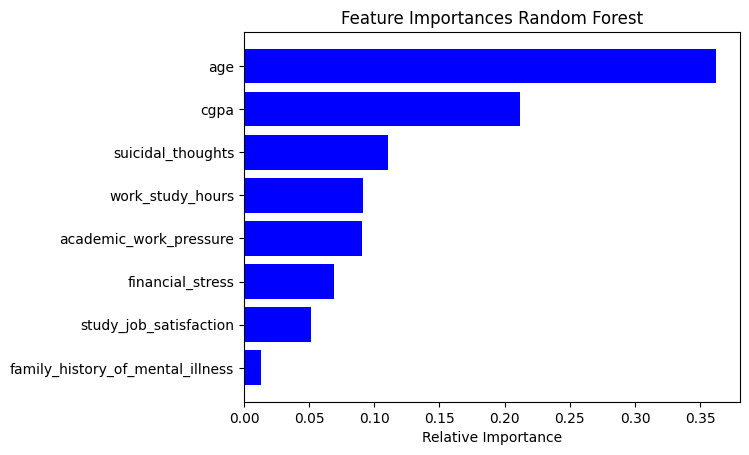

In [129]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



<center><img src="https://cdn.prod.website-files.com/646218c67da47160c64a84d5/64634be786d11debe86c8c42_86.png" width=200 height=200 /></center>